## Totale 4/06/2019
### Esercizio 1 Punto 2
Alessandro Lodi<br>
Matricola 274425

### Notebook Init

In [1]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class args:
    filename = "graph04062019R1.gml"
    scale = 40
    figsize = 10,10

In [4]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

### Drawing functions

In [5]:
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        
    plt.axis('off')
    plt.show()

In [6]:
# Graph reading
basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 30 nodes and 435 edges


## Prize Collecting Steiner Tree (PCST) with limited number of hops  

### Problem definition

>**Given**
>A symmetric graph $G=(V,E)$ and a cost $c_e > 0$ for each edge in $E$.
>A root node $\{0\}$.
>A revenue $p_j > 0$ for each node $j \in V \setminus \{0\}$.
>
>**Find**
>A subtree 𝑇 rooted in {0} that maximizes the sum of the revenues of the nodes in 𝑇 minus the sum of the cost of the edges in 𝑇 such that the distance between {0} and any node in 𝑇 does not exceed H.

### Directed formulation

Consider the bidirected graph $B=(V,A)$ that is obtained from $G$ by replacing each edge $e = \{i, j\}$ in $E$ with two directed arcs $(i, j)$ and
$(j, i)$ (with corresponding weights $c_{ij} = c_{ji} = c_e )$ and a cost $c_e > 0$ for each edge in $E$



> **PCST-H** is equivalent to find an optimal arborescence in B rooted in $\{0\}$


#### Variables
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the arborescence} \\
0 \text{ otherwise}
\end{cases}
$$

$$
y_j = \begin{cases} 1 \text{ if node j is in the arborescence}\\
0 \text{ otherwise}
\end{cases}
$$

$$ 
u_j = \{\text{number of arcs in the dipath (if any) induced by $x$ from \{0\} to $j$}\}
$$

#### MTZ formulation

$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} - \sum_{j \in V \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V \setminus \{0\}\\
(h+1)x_{ij} + u_i - u_j &\le h \;\; \forall (i,j) \in A \\
y_i \le u_i &\le h y_i \;\; \forall i \in V\setminus \{0\}\\ 
x_{jk} &\le y_j \;\; \forall k \in \delta^+(j), \;\; \forall j \in V \setminus\{0\}\\
0 \le u_j & \le n \;\; \forall j \in V \\ 
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V
\end{align}
$$


In [7]:
D = G.to_directed()
G.nodes(data=True)

NodeDataView({1: {'y': 65, 'x': 10, 'revenue': 310}, 2: {'y': 19, 'x': 9, 'revenue': 843}, 3: {'y': 8, 'x': 35, 'revenue': 1578}, 4: {'y': 17, 'x': 1, 'revenue': 813}, 5: {'y': 35, 'x': 21, 'revenue': 1452}, 6: {'y': 57, 'x': 15, 'revenue': 1031}, 7: {'y': 5, 'x': 26, 'revenue': 487}, 8: {'y': 20, 'x': 30, 'revenue': 491}, 9: {'y': 50, 'x': 29, 'revenue': 559}, 10: {'y': 19, 'x': 34, 'revenue': 622}, 11: {'y': 34, 'x': 5, 'revenue': 917}, 12: {'y': 1, 'x': 34, 'revenue': 1175}, 13: {'y': 12, 'x': 23, 'revenue': 1064}, 14: {'y': 22, 'x': 11, 'revenue': 930}, 15: {'y': 37, 'x': 11, 'revenue': 1354}, 16: {'y': 12, 'x': 19, 'revenue': 1259}, 17: {'y': 12, 'x': 3, 'revenue': 511}, 18: {'y': 32, 'x': 28, 'revenue': 1169}, 19: {'y': 45, 'x': 1, 'revenue': 679}, 20: {'y': 37, 'x': 14, 'revenue': 432}, 21: {'y': 55, 'x': 1, 'revenue': 1089}, 22: {'y': 36, 'x': 27, 'revenue': 386}, 23: {'y': 34, 'x': 23, 'revenue': 1099}, 24: {'y': 42, 'x': 13, 'revenue': 1326}, 25: {'y': 24, 'x': 11, 'revenue':

In [8]:
root = 1
pcst = gb.Model()

# H represents the maximum number of hops
H = 4

# Objective function
pcst.ModelSense = gb.GRB.MAXIMIZE


# Decision Variables
x = pcst.addVars(D.edges(), vtype=gb.GRB.BINARY, 
                 obj = [- D[i][j]['cost'] for i,j in D.edges()], 
                 name = 'x')

y = pcst.addVars (G.nodes(), vtype = gb.GRB.BINARY, 
                  obj = [G.nodes[i]['revenue'] for i in G.nodes()],
                 name = 'y')

u = pcst.addVars (G.nodes(), vtype = gb.GRB.CONTINUOUS, 
                  lb = 0.0, ub = G.number_of_nodes(),
                 name = 'u')


# Root is in the solution
pcst.addConstr(y[root] == 1, name = 'Fix_root')


# Each node has exactly one incoming arc
pcst.addConstrs((x.sum('*',j) == y[j] for j in G.nodes() if j != root), name='Node_in_deg')


# Precedence constraints (MTZ constraints)
pcst.addConstrs(((G.number_of_nodes() +  1) * x[i,j] + u[i] - u[j] <= G.number_of_nodes() for i,j in D.edges()),
                name = 'MTZ')


# Connectivity constraints
pcst.addConstrs((x[j,k] <= y[j] for j in G.nodes()
                 if j != root for k in D.neighbors(j)), name = 'Connect')

# Hop Constraints
pcst.addConstrs ((u[i] >= y[i] for i in G.nodes()
                  if i != root), name='VLB')

pcst.addConstrs ((u[i] <= H * y[i] for i in G.nodes()
                  if i != root), name='VUB')

pcst.update()
pcst.write('pcst.lp')

Academic license - for non-commercial use only - expires 2021-07-30
Using license file /opt/gurobi/gurobi.lic


In [9]:
pcst.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1799 rows, 930 columns and 5279 nonzeros
Model fingerprint: 0x83369fd5
Variable types: 30 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 7e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 310.0000000
Presolve removed 59 rows and 31 columns
Presolve time: 0.02s
Presolved: 1740 rows, 899 columns, 5104 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)

Root relaxation: objective 1.373380e+04, 88 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 13733.8000    0   24  310.00000 13733.8000  4330%     -    0s
H    0     0                    1424.0000000 13

Optimal value:  9649.0


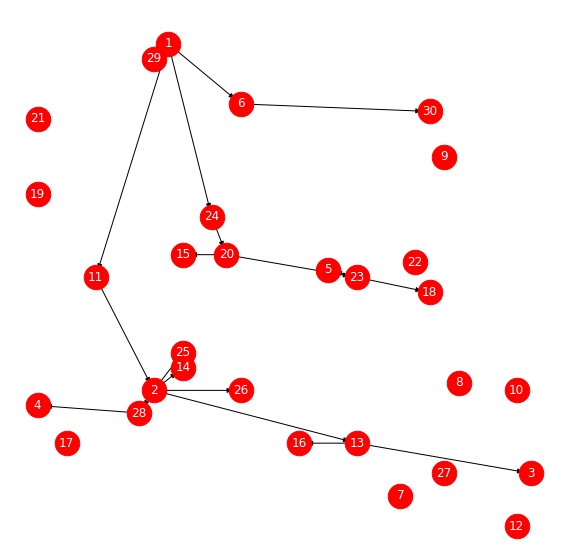

In [10]:
print("Optimal value: ", pcst.objVal)
DrawSol(D,x)